# **1. Importing Required Libraries**

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Text processing
import re
import string
import nltk

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **2. Loading and Combining the Dataset**

In [2]:
# Load datasets
fake_df = pd.read_csv("/content/Fake.csv")
true_df = pd.read_csv("/content/True.csv")

# Add labels
fake_df['label'] = 0   # Fake news
true_df['label'] = 1   # Real news

# Combine datasets
df = pd.concat([fake_df, true_df], axis=0)

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


# **3. Exploratory Data Analysis (EDA)**

## *Class Distribution*

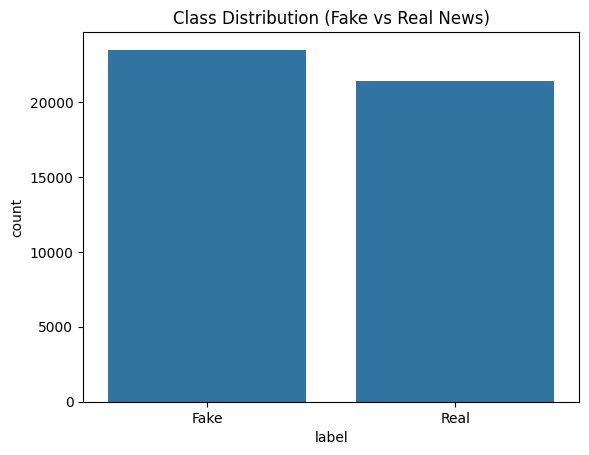

In [3]:
sns.countplot(x='label', data=df)
plt.title("Class Distribution (Fake vs Real News)")
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

## *Word Count Analysis*

In [4]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

df.groupby('label')['text_length'].mean()

,text_length
label,
0,423.197905
1,385.640099


# **4. Text Preprocessing Pipeline**

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Removing URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Removing numbers
    text = re.sub(r'\d+', '', text)

    # Tokenization & stopword removal
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

# Applying preprocessing
df['clean_text'] = df['text'].apply(clean_text)

# **5. Rule-Based Classifier**

In [6]:
fake_keywords = [
    "breaking", "shocking", "exposed", "hoax", "conspiracy",
    "clickbait", "fraud", "unbelievable"
]

def rule_based_classifier(text):
    for word in fake_keywords:
        if word in text:
            return 0  # Fake
    return 1  # Real

df['rule_pred'] = df['clean_text'].apply(rule_based_classifier)

# Evaluating rule-based model
print("Rule-Based Accuracy:", accuracy_score(df['label'], df['rule_pred']))

Rule-Based Accuracy: 0.524611341262417


# **6. Feature Extraction using TF-IDF**

In [7]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# **7. Machine Learning Models**

## *7.1 Naive Bayes*

In [8]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

nb_pred = nb_model.predict(X_test_tfidf)

## *7.2 Logistic Regression*

In [9]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

lr_pred = lr_model.predict(X_test_tfidf)

## *7.3 Support Vector Machine (SVM)*

In [10]:
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

svm_pred = svm_model.predict(X_test_tfidf)

# **8. Evaluation & Comparison**

In [11]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Model Performance")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

evaluate_model("Naive Bayes", y_test, nb_pred)
evaluate_model("Logistic Regression", y_test, lr_pred)
evaluate_model("SVM", y_test, svm_pred)


Naive Bayes Model Performance
Accuracy: 0.9584632516703786
Precision: 0.9473804621368108
Recall: 0.9666199813258637
F1 Score: 0.9569035239745811

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      4696
           1       0.95      0.97      0.96      4284

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980


Logistic Regression Model Performance
Accuracy: 0.9905345211581291
Precision: 0.986107895346145
Recall: 0.9941643323996265
F1 Score: 0.9901197256770894

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      898

## *Naïve Bayes ROC–AUC* *italicized text*

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities
nb_probs = nb_model.predict_proba(X_test_tfidf)[:, 1]

# ROC-AUC score
nb_auc = roc_auc_score(y_test, nb_probs)
print("Naive Bayes ROC-AUC:", nb_auc)

Naive Bayes ROC-AUC: 0.9895595731194238


## *Logistic Regression ROC–AUC*

In [13]:
# Predict probabilities
lr_probs = lr_model.predict_proba(X_test_tfidf)[:, 1]

# ROC-AUC score
lr_auc = roc_auc_score(y_test, lr_probs)
print("Logistic Regression ROC-AUC:", lr_auc)

Logistic Regression ROC-AUC: 0.9993736847379497


## *ROC–AUC for SVM*

In [14]:
# Decision function scores
svm_scores = svm_model.decision_function(X_test_tfidf)

# ROC-AUC score
svm_auc = roc_auc_score(y_test, svm_scores)
print("SVM ROC-AUC:", svm_auc)

SVM ROC-AUC: 0.9997719914200774


## *ROC Curve Visualisation*

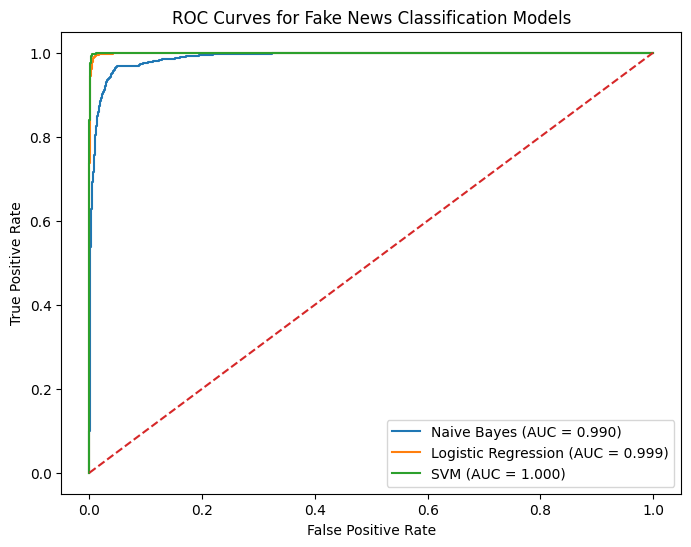

In [15]:
# Compute ROC curves
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_scores)

# Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.3f})')
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.3f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.3f})')

# Diagonal reference line
plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Fake News Classification Models')
plt.legend()
plt.show()

## *Confusion Matrix Visualisation*

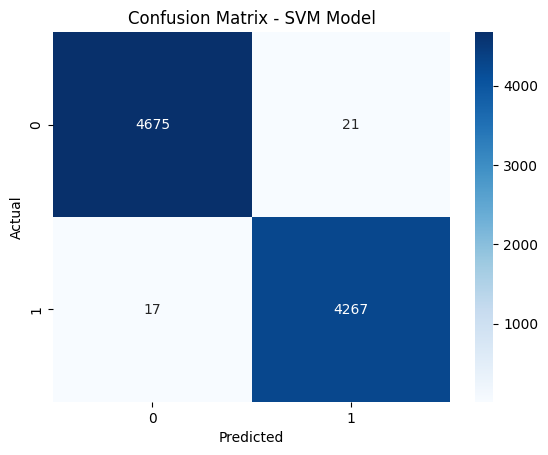

In [16]:
cm = confusion_matrix(y_test, svm_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM Model")
plt.show()

# **9. Word Cloud**

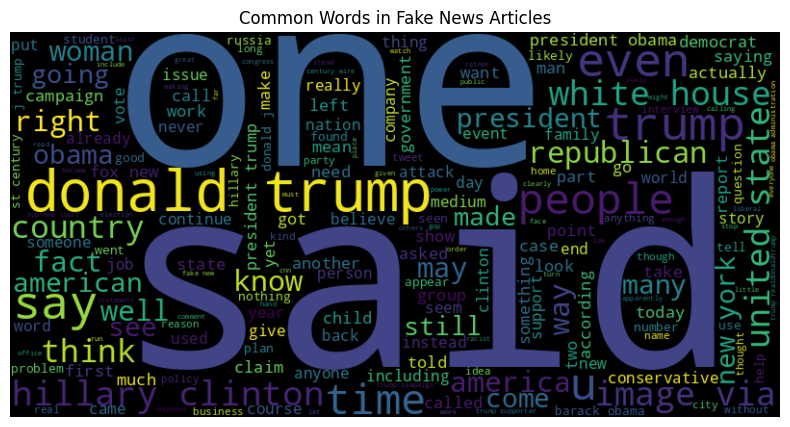

In [17]:
fake_text = " ".join(df[df['label'] == 0]['clean_text'])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black'
).generate(fake_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Fake News Articles")
plt.show()